# 3. GAN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book/blob/master/book/chapters/GAN/Ch3-GAN.ipynb)

2장에서는 Victorain400 데이터셋의 이미지를 폴더별로 시각화 해보았습니다. 3장에서는 본격적으로 GAN을 이용하여 흑백 이미지를 컬러 이미지로 변환시키는 모델을 구축해보도록 하겠습니다.


3.1절에서는 모델링에 사용할 데이터를 불러오고, 3.2절에서는 데이터셋 클래스를 정의하여 데이터 로더까지 정의하도록 하겠습니다. 3.3절에서는 Generator 클래스와 Discriminator 클래스를 정의하여 모델을 구축해보겠습니다. 그리고 3.4절에서는 하이퍼파라미터를 설정하여 구축된 모델을 학습시킨 후, 3.5절에서 테스트 데이터에 대한 예측과 성능평가를 해보도록 하겠습니다.

## 3.1 데이터셋 다운로드

2.1절에서 나온 코드를 활용하여 모델에 사용할 데이터셋을 내려받도록 하겠습니다. 가짜연구소 깃허브의 Tutorial-Book-Utils를 `clone`하고 PL_data_loader.py 파일로 Victorian400 데이터셋을 내려받아 압축을 푸는 순서입니다.

In [1]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data GAN-Colorization
!unzip -q Victorian400-GAN-colorization-data.zip

이번에는 3장에서 사용할 패키지들을 불러오겠습니다. `os`와 `glob`는 파일 경로를 지정할 수 있는 패키지이며, `datetime`은 날짜, 시간을 계산할 수 있는 패키지입니다. 그리고 `numpy`는 수치 연산에 사용되는 선형 대수 패키지이며, `matplotlib`과 `PIL`의 `Image`는 이미지 파일 시각화하는데 사용하는 패키지입니다. 그 외의 `torch`와 `torchvision` 패키지는 데이터셋 정의와 모델 구축에 사용되는 Torch 기반의 패키지들입니다.

In [2]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

## 3.2 데이터셋 클래스 정의

파이토치 모델에 데이터를 학습하기 위해서 데이터셋 클래스를 정의해보도록 하겠습니다. 이미지 변환(transforms)과 흑백, 컬러 이미지의 폴더 경로를 인자로 받아 `Image.open` 함수를 사용하여 해당 이미지를 불러옵니다. 흑백 이미지는 `.convert("L")`을 사용하여 단일 채널로, 컬러 이미지는 `.convert("RGB")`을 사용하여 3채널로 받아줍니다. 그리고 이미지 변환을 거쳐 딕셔너리 형태로 흑백 이미지와 컬러 이미지를 "A", "B"에 각각 반환시켜줍니다.

In [3]:
class VictorianDataset(Dataset):
    def __init__(self, root, transforms_=None):

        self.transform = transforms.Compose(transforms_)
        self.gray_files = sorted(glob.glob(os.path.join(root, 'gray') + "/*.*"))
        self.color_files = sorted(glob.glob(os.path.join(root, 'resized') + "/*.*"))
     
    def __getitem__(self, index):

        gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert("L")
        color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")
    
        gray_img = self.transform(gray_img)
        color_img = self.transform(color_img)

        return {"A": gray_img, "B": color_img}

    def __len__(self):
        return len(self.gray_files)


이미지 경로와 사이즈, 각 데이터셋의 배치사이즈를 지정해줍니다. 이미지 사이즈와 배치사이즈는 각자의 환경(최대 메모리 사용량)에 맞춰 설정해주면 됩니다. 단, 이후에 나올 모델 구조가 256으로 고정되어 있어 다른 이미지 사이즈를 원하실 경우 모델 구조도 약간의 수정이 필요합니다.

In [4]:
root = ''
test_root = root + 'test/'

img_height = 256
img_width = 256

batch_size = 12
test_batch_size = 6

gpu = 0

데이터셋 클래스의 인자로 넣을 이미지 변환(transform)을 지정합니다. 튜토리얼에서는 파이토치 모델에 넣기 위해 tensor 타입으로 바꿔주기만 하겠습니다. 이 외에도 모델 구조에 따라 `Resize`를 해줄 수도 있고, 도메인에 따라 `RandomCrop`(랜덤으로 자르기), `RandomVerticalFlip`(랜덤으로 수평 뒤집기) 등 다양한 이미지 변형을 할 수 있습니다. 또한 `normalize`를 통해 학습의 일반화 성능을 향상시킬 수도 있습니다.

In [5]:
transforms_ = [
    # transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

위에서 정의한 데이터셋 클래스와 이미지 변환(transform)을 `DataLoader`함수에 넣어줍니다.

In [6]:
train_loader = DataLoader(
    VictorianDataset(root, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True
)

데이터 로더가 제대로 구성되어 있는지 시각화를 통해 알아보겠습니다. "A"에 해당하는 흑백 이미지는 단일 채널이기 때문에 `.reshape()`을 통해 2차원으로 바꿔주고 `cmap=gray`를 설정해주어야 이미지를 제대로 출력할 수 있습니다.

torch.Size([12, 1, 256, 256]) torch.Size([12, 3, 256, 256])


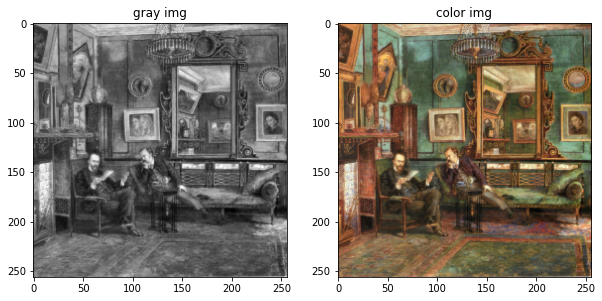

In [7]:
fig = plt.figure(figsize=(10,5))
rows = 1 
cols = 2

for X in train_loader:
    
    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(np.clip(np.transpose(X["A"][0], (1,2,0)).reshape(img_height, img_width), 0, 1), cmap='gray')
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(np.clip(np.transpose(X["B"][0], (1,2,0)), 0, 1))
    ax2.set_title('color img')    

    plt.show()
    break

데이터 로더가 제대로 구성되어 흑백 이미지와 컬러 이미지가 잘 출력되고 있습니다. 단, 이미지 사이즈가 너무 작으면 해상도가 낮을 수 있으니 적절한 이미지 사이즈를 설정해주어야 합니다.

마찬가지로 테스트 데이터 로더도 정의하고 시각화해보겠습니다.

In [8]:
test_loader = DataLoader(
    VictorianDataset(test_root, transforms_=transforms_),
    batch_size=test_batch_size,
    shuffle=True
)

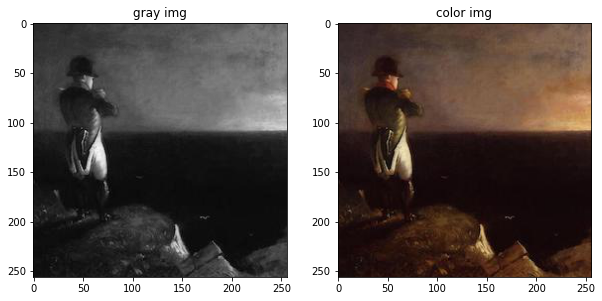

In [9]:
fig = plt.figure(figsize=(10,5))
rows = 1 
cols = 2

for X in test_loader:
    
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(np.clip(np.transpose(X["A"][0], (1,2,0)).reshape(img_height, img_width), 0, 1), cmap='gray')
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(np.clip(np.transpose(X["B"][0], (1,2,0)), 0, 1))
    ax2.set_title('color img')    

    plt.show()
    break

테스트 데이터 로더도 잘 구성된 것을 확인할 수 있습니다. 

## 3.3 모델 구축

이번에는 데이터셋을 학습시킬 모델을 구축해보도록 하겠습니다. 3.3절에서는 GAN 모델을 사용하여 흑백 이미지를 컬러 이미지로 변환시켜볼 것 입니다. GAN 모델은 생성 모델(Generator)과 판별 모델(Discriminator)로 이루어져 있습니다. 각각은 `Conv2d`와 `ConvTranspose2d`, `MaxPool2d`, 정규화, 활성화함수들로 이루어져 있습니다. 

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        """noise image + gray image"""
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )
        
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64 * 2 , 3, 1, 1),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.1)
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        self.conv1by1 = nn.Sequential(
            nn.Conv2d(64,64,1,1,0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )
        
        
        self.conv = nn.Sequential(
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, input):
        output1 = self.conv1(input)
        pool1 = self.maxpool(output1)
        output2 = self.conv2(pool1)
        output3 = self.upsample(output2) + output1
        output4 = self.conv1by1(output3)
        out = self.conv(output4)        
        return out

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(64,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(128, 128, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(512, 1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace = True),
            
            )
        
        
        self.fc = nn.Sequential(
            nn.Linear(1024 * 8 * 8 , 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, batch_size),
            nn.Sigmoid()
        )
        
    def forward(self, input, b_size):
        output = self.main(input)
        output = self.fc(output.view(b_size,-1))
        return output

학습시 배치마다 가중치를 초기화 시켜주어야 합니다. 따라서 `weights_init` 함수를 만들어 생성 모델(Generator)과 판별 모델(Discriminator)에 붙여줍니다.

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:        
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1: 
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

그리고 생성 모델(Generator)과 판별 모델(Discriminator)을 GPU에서 학습시키기 위해 `.cuda(gpu)`를 통해 모델을 전달해줍니다. 이 때, `gpu`에는 위에서 지정한 device가 들어갑니다. 출력되는 것을 통해 모델 구조를 확인할 수 있습니다.

In [13]:
Gener = Generator().cuda(gpu) if torch.cuda.is_available() else Generator()
Gener.apply(weights_init)

Generator(
  (conv1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv1by1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(nega

In [14]:
Discri = Discriminator().cuda(gpu) if torch.cuda.is_available() else Discriminator()
Discri.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, af

## 3.4 모델 학습

이제 구축된 모델을 학습시켜보겠습니다. 학습 횟수는 50으로 지정하고, 생성모델과 판별모델 모두 Adam 최적화 방법을 사용해보겠습니다. 각 하이퍼파라미터는 튜닝하여 다양한 실험을 해볼 수 있습니다. 

학습은 생성모델, 판별모델 순으로 진행됩니다. 생성모델에서는 판별모델을 속일 수 있는 컬러 이미지를 생성하도록 학습합니다. 그리고 판별모델에서는 컬러 이미지를 진짜(real)로, 흑백 이미지를 가짜(fake)로 인식하도록 학습합니다.

In [15]:
max_epoch = 50
optimizerD = torch.optim.Adam(Discri.parameters(), lr = 0.0002,betas = (0.5, 0.999))
optimizerG = torch.optim.Adam(Gener.parameters(), lr = 0.0002, betas = (0.5, 0.999))

[Epoch 5/50] [Batch 34/34] [D loss: 0.629986] [G loss: 0.219832] ETA: 0:00:15.401804


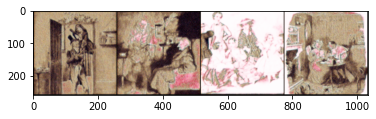

[Epoch 10/50] [Batch 34/34] [D loss: 0.172324] [G loss: 0.913297] ETA: 0:00:15.415766


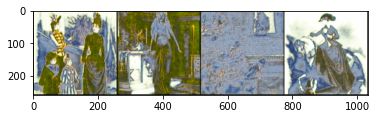

[Epoch 15/50] [Batch 34/34] [D loss: 0.061855] [G loss: 0.892983] ETA: 0:00:15.377866


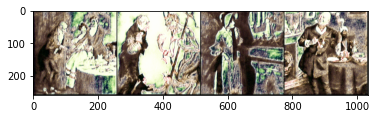

[Epoch 20/50] [Batch 34/34] [D loss: 0.003120] [G loss: 0.976844] ETA: 0:00:15.398811


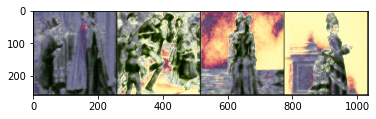

[Epoch 25/50] [Batch 34/34] [D loss: 0.020883] [G loss: 0.989808] ETA: 0:00:15.404794


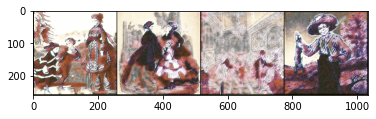

[Epoch 30/50] [Batch 34/34] [D loss: 0.009227] [G loss: 0.963132] ETA: 0:00:15.456656


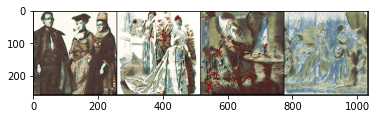

[Epoch 35/50] [Batch 34/34] [D loss: 0.075800] [G loss: 0.942878] ETA: 0:00:15.410779


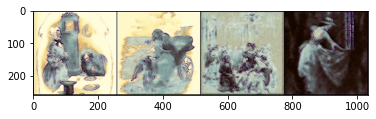

[Epoch 40/50] [Batch 34/34] [D loss: 0.000064] [G loss: 0.999627] ETA: 0:00:15.538437


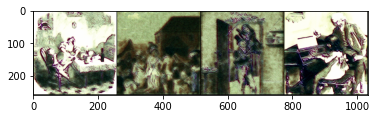

[Epoch 45/50] [Batch 34/34] [D loss: 0.110793] [G loss: 0.999985] ETA: 0:00:15.647146


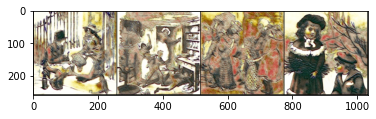

[Epoch 50/50] [Batch 34/34] [D loss: 0.001532] [G loss: 0.999124] ETA: 0:00:15.509515


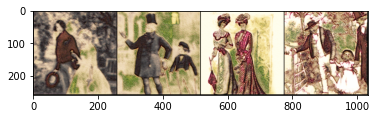

In [16]:
for epoch in range(max_epoch):
    start_time = datetime.datetime.now()
    loss_D = 0.0
    for i, data in enumerate(train_loader):
        gray, color = data['A'], data['B']
        b_size = len(data['A'])

        color = torch.from_numpy(np.resize(color.numpy(), (b_size, 3, img_height, img_width))) 
        grays = torch.from_numpy(np.resize(gray.numpy(), (b_size, 1, img_height, img_width))) 


        ######## 생성모델(Generator) 학습 ########
        ######## Train Generator ########
        noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)
        gray_noise = Variable(torch.cat([grays,noise],dim=1).cuda(gpu))
        fake_img = Gener(gray_noise)
        output = Discri(fake_img,b_size)
        g_loss = torch.mean((output-1)**2)
        

        ######## 역전파 & 생성모델 최적화 ########
        ######## Backpropagation & Optimize G ########
        Discri.zero_grad()
        Gener.zero_grad()
        g_loss.backward()
        optimizerG.step()


        ######## 판별모델(Discriminator) 학습 ########
        ######## Train Discriminator ########
        color = Variable(color.cuda(gpu))
        noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)   
        gray_noise2 = Variable(torch.cat([grays,noise],dim=1).cuda(gpu))   


        ######## 판별모델이 컬러 이미지를 진짜(real)로 인식하도록 학습 ########
        ######## Train d to recognize color image as real ########
        output = Discri(color,b_size)
        real_loss = torch.mean((output-1)**2)
        

        ######## 판별모델이 흑백 이미지를 가짜(fake)로 인식하도록 학습 ########
        ######## Train d to recognize fake image as fake ########        
        fake_img = Gener(gray_noise2)   
        output = Discri(fake_img,b_size)
        fake_loss = torch.mean(output**2)
        

        ######## 역전파 & 판별모델 최적화 ########
        ######## Backpropagation & Optimize D ########
        d_loss = real_loss + fake_loss
        Discri.zero_grad()
        Gener.zero_grad()
        d_loss.backward()
        optimizerD.step()        


        fake_img = torchvision.utils.make_grid(fake_img.data) 

    epoch_time = datetime.datetime.now() - start_time
    if (epoch + 1) % 5 == 0:
        torch.save(Gener.state_dict(), "generator_%d.pth" % (epoch+1))
        torch.save(Discri.state_dict(), "discriminator_%d.pth" % (epoch+1))

        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] ETA: %s" % (epoch+1, max_epoch, i+1, len(train_loader), d_loss.item(), g_loss.item(), epoch_time))
        plt.imshow(np.clip(fake_img.cpu().numpy().transpose((1,2,0)), 0, 1))
        plt.show()      

5에폭마다 생성모델과 판별모델의 가중치를 저장하여 나중에 학습된 모델을 재구현할 수 있도록 합니다. 그리고 각 모델의 로스값과 생성모델에서 생성한 이미지를 출력하여 어떻게 학습되고 있는지 확인합니다. 

생성모델의 로스와 판별모델의 로스의 관계를 확인하여 적절한 에폭 수를 결정하는 것이 중요합니다. 그렇지 못할 경우, 한 모델에 오버피팅되어 더 이상의 학습이 무의미해지게 됩니다.

## 3.5 예측 및 성능 평가

학습이 끝났으니 새로운 흑백 이미지에 적용하여 컬러 이미지로 예측(채색)해보도록 하겠습니다. 위에서 학습한 모델의 가중치를 불러오고 테스트 데이터 로더의 이미지를 넣어 예측하게 됩니다. 튜토리얼에서는 마지막 50에폭의 가중치를 불러오도록 하겠습니다. 중간에 오버피팅된 경향이 보인다면 원하시는 에폭의 가중치를 불러와도 됩니다.

In [31]:
Gener.load_state_dict(torch.load("generator_50.pth" ))
Discri.load_state_dict(torch.load("discriminator_50.pth" ))

<All keys matched successfully>

==================input==================


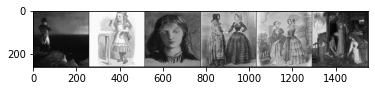

==================target==================


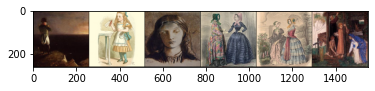

==================output==================


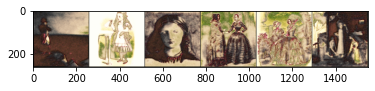

In [36]:
Discri.eval()
Gener.eval()

fixed_noise = torch.randn(test_batch_size, 1, img_height, img_width).uniform_(0,1)

for i, data in enumerate(test_loader,0) :
    images, label = data['A'], data['B']

    if len(data['A']) != test_batch_size:
        continue

    grays = torch.from_numpy(np.resize(images.numpy(), (test_batch_size, 1, img_height, img_width)))    
    gray = Variable(torch.cat([grays,fixed_noise],dim = 1).cuda(gpu))
    
    output = Gener(gray)

    inputs = torchvision.utils.make_grid(grays)
    labels = torchvision.utils.make_grid(label)
    out = torchvision.utils.make_grid(output.data)

    print('==================input==================')
    plt.imshow(np.clip(inputs.cpu().numpy().transpose((1,2,0)), 0, 1))
    plt.show()
    print('==================target==================')
    plt.imshow(np.clip(labels.cpu().numpy().transpose((1,2,0)), 0, 1))
    plt.show()
    print('==================output==================')
    plt.imshow(np.clip(out.cpu().numpy().transpose((1,2,0)), 0, 1))
    plt.show()

결과는 흑백(input), 컬러(target), 생성된 이미지(output)순으로 출력되어집니다. 선명하진 않지만 비슷한 색감이 어느 정도 채색된 것을 볼 수 있습니다.

지금까지 3장에서 흑백 이미지를 컬러 이미지로 바꾸는 생성모델 GAN을 구축해보았습니다. 다음 장에서는 채색에 더 특화되어있는 pix2pix모델을 사용하여 비교해보도록 하겠습니다.